In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/tcc')
'''


In [ ]:
from preprocessing import *

In [ ]:
import pickle
import pandas as pd
from tqdm import tqdm
import gensim


datasets = pickle.load(open("dataset/organized_dataset.pkl", "rb"))

df = pd.DataFrame(datasets, columns = ['text', 'tokens', 'source', 'label', 'anger','disgust','fear', 'joy', 'love', 'noemo', 'sadness', 'surprise']) 
df.drop_duplicates(['source'])

In [ ]:
## config
size_word2vec = 300
maxlen = MAX_SEQUENCE_LENGTH = 35


sentiments = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [ ]:
filename = 'models/ft_'+str(size_word2vec)+'.pkl'

try:
    w2v = pickle.load(open(filename, 'rb'))
except:
    w2v = gensim.models.FastText(df['tokens'].values,size=size_word2vec, workers=8)
    # w2v = gensim.models.Word2Vec(df['tokens'].values,size=size_word2vec, workers=8, compute_loss=True, )
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(w2v, output, pickle.HIGHEST_PROTOCOL)

MAX_NB_WORDS = len(w2v.wv.vocab)
nb_words = min(MAX_NB_WORDS, len(w2v.wv.vocab))


# training_loss = w2v.get_latest_training_loss()
# print(training_loss)

print(w2v.wv.most_similar(positive=['woman', 'king'], negative=['man']))
print(w2v.wv.most_similar('gr8'))
print(w2v.wv.most_similar('new_york'))
print(w2v.wv.most_similar('twitter_usernam'))

In [9]:
sentData = df.loc[df['source'].isin(['dailydialog', 'electoraltweets', 'crowdflower'])]
sentData.drop_duplicates(['source'])

,text,tokens,source,label,anger,disgust,fear,joy,love,noemo,sadness,surprise
12647,@tiffanylue i know i was listenin to bad habi...,"[twitterusernam, i, know, , i, wa, listenin, t...",crowdflower,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12648,Layin n bed with a headache ughhhh...waitin o...,"[layin, n, bed, with, a, headach, , ughhhh, wa...",crowdflower,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12649,Funeral ceremony...gloomy friday...,"[funer, ceremoni, gloomi, friday]",crowdflower,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12650,wants to hang out with friends SOON!,"[want, to, hang, out, with, friend, soon]",crowdflower,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12651,@dannycastillo We want to trade with someone w...,"[twitterusernam, we, want, to, trade, with, so...",crowdflower,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
189000,"Well , thank you very much for all that inform...","[well, thank, you, veri, much, for, all, that,...",dailydialog,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0
189001,Are you going to make an offer today ?,"[are, you, go, to, make, an, offer, today]",dailydialog,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0
189002,Yes . My customer is in urgent need of the ste...,"[ye, my, custom, is, in, urgent, need, of, the...",dailydialog,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0
189003,"Ok , I'll get this rate right away .","[ok, i, 'll, get, thi, rate, right, away]",dailydialog,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import random

def getIndex(t):
    try:
        return w2v.wv.vocab[t].index
    except:
        return 0
sentData[sentiments].sum()

def getSentData(sentiment):
    labels = [sentiment]# ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

    sequences = [[getIndex(t) for t in comment]
                for comment in sentData['tokens']]

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    y = sentData[labels].values
    # print('Shape of data tensor:', data.shape)
    # print('Shape of label tensor:', y.shape)

    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)
    #random over sample
    ros = RandomOverSampler(random_state=42)
    # define the undersampling method
    undersample = NearMiss(version=1, n_neighbors=3)
    # transform the dataset
    x_test, y_test = ros.fit_resample(x_test, y_test)

    x_train, y_train = ros.fit_resample(x_train, y_train)

    return x_train, y_train, x_test, y_test

In [ ]:
import tensorflow as tf

def model_gru(embedding_matrix, embed_size):

    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
 
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(35, return_sequences=True))(x)
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
    conc = tf.keras.layers.concatenate([avg_pool, max_pool])
    conc = tf.keras.layers.Dense(70, activation="relu")(conc)

    conc = tf.keras.layers.Dropout(0.5)(conc)
    outp = tf.keras.layers.Dense(1, activation="sigmoid")(conc)
    model = tf.keras.models.Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model








  0%|          | 0/6 [00:00<?, ?it/s]

ANGER
900/900 [==============================] - 4s 4ms/step - loss: 7.0328 - accuracy: 0.6326
Best threshold:  0.11
Optimal F1: 0.47873952126047875 at threshold: 0.11
Test Loss: 7.032818794250488
Test Accuracy: 0.6326155066490173


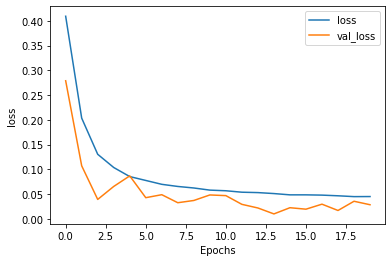

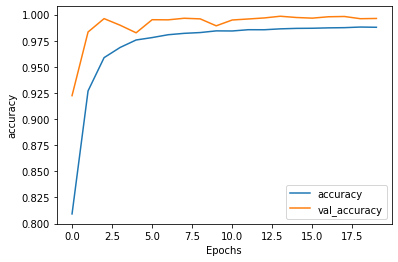








 17%|█▋        | 1/6 [03:43<18:35, 223.20s/it]

DISGUST
904/904 [==============================] - 4s 4ms/step - loss: 4.3560 - accuracy: 0.8326
Best threshold:  0.1
Optimal F1: 0.8119567866135975 at threshold: 0.1
Test Loss: 4.356029987335205
Test Accuracy: 0.8326300382614136


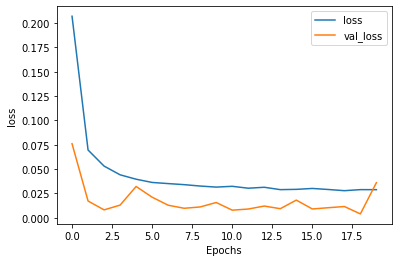

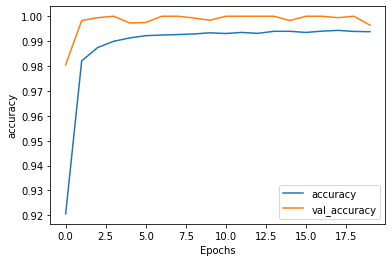








 33%|███▎      | 2/6 [07:28<14:55, 223.93s/it]

FEAR
865/865 [==============================] - 3s 4ms/step - loss: 3.0486 - accuracy: 0.7355
Best threshold:  0.1
Optimal F1: 0.725116373203805 at threshold: 0.1
Test Loss: 3.048616647720337
Test Accuracy: 0.7355153560638428


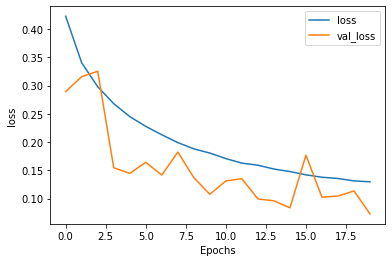

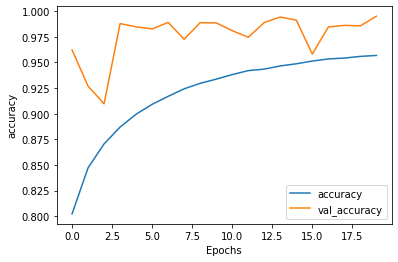








 50%|█████     | 3/6 [11:02<11:02, 220.72s/it]

JOY
777/777 [==============================] - 3s 4ms/step - loss: 1.2664 - accuracy: 0.7399
Best threshold:  0.1
Optimal F1: 0.7404333426439487 at threshold: 0.1
Test Loss: 1.2664376497268677
Test Accuracy: 0.7398936748504639


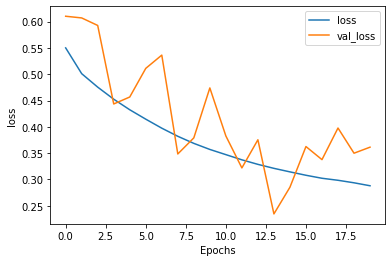

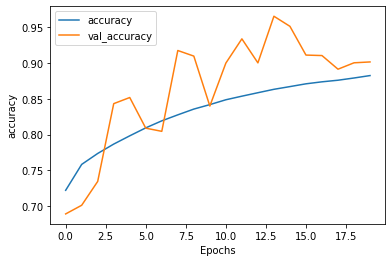








 67%|██████▋   | 4/6 [14:15<07:04, 212.43s/it]

SADNESS
880/880 [==============================] - 3s 4ms/step - loss: 5.5032 - accuracy: 0.6637
Best threshold:  0.1
Optimal F1: 0.6042451529909032 at threshold: 0.1
Test Loss: 5.50322961807251
Test Accuracy: 0.6636712551116943


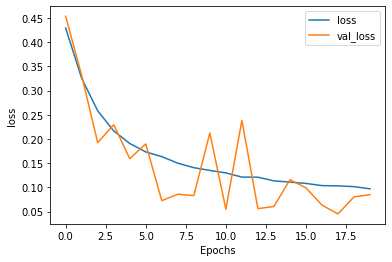

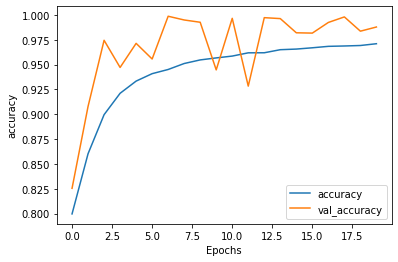








 83%|████████▎ | 5/6 [17:51<03:33, 213.66s/it]

SURPRISE
891/891 [==============================] - 3s 4ms/step - loss: 7.1659 - accuracy: 0.6519
Best threshold:  0.1
Optimal F1: 0.5179442168909695 at threshold: 0.1
Test Loss: 7.165855884552002
Test Accuracy: 0.6519449353218079


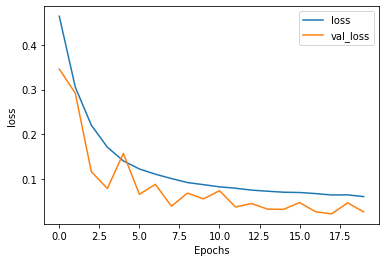

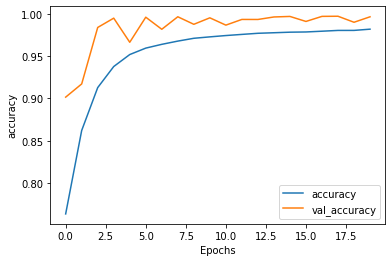








100%|██████████| 6/6 [21:33<00:00, 215.62s/it]


In [28]:
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def f1_smart(y_true, y_pred):
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = metrics.f1_score(y_true, (y_pred > thresh).astype(int))
        thresholds.append([thresh, res])
        printout = "F1 score at threshold {0} is {1}".format(thresh, res)
        # print(printout)
    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    best_f1 = thresholds[0][1]
    print("Best threshold: ", best_thresh)
    return best_f1, best_thresh

def train(sentiment):
    model = model_gru(w2v.wv.vectors, size_word2vec)

    x_train, y_train, x_test, y_test = getSentData(sentiment)
    hist = model.fit(x_train, y_train,
                        validation_split=0.1,
                        epochs=20,
                        batch_size=250,
                        shuffle=True, # ?
                        verbose=0)
    print(sentiment.upper())
    score = model.evaluate(x_test, y_test, verbose=1)
    y_pred_test = model.predict([x_test], batch_size=250, verbose=0)

    f1, threshold = f1_smart(y_test, y_pred_test)
    printout = 'Optimal F1: {} at threshold: {}'.format(f1, threshold)
    print(printout)
    print("Train Loss:", hist.history['loss'][-1])
    print("Train Accuracy:", hist.history['accuracy'][-1]))

    plot_graphs(hist, 'loss')
    plot_graphs(hist, 'accuracy')
    
    return model

models = dict()
for s in tqdm(sentiments):
    models[s] = train(s)

In [ ]:
def getModelInput(phrase):
    x = cleanText(phrase)
    x = [getIndex(t) for t in x]
    x = pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)
    return x

def getEmotions(phrase):
    # sentiments = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
    x = getModelInput(phrase)
    return [models[s].predict(x) for s in sentiments]

In [ ]:
model_json = model_gru(w2v.wv.vectors, size_word2vec).to_json()
with open("models/bi-gru"+str(size_word2vect)+".json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
for s in sentiments:
    models[s].save_weights('models/'+s+'_weights.h5')